In [1]:
!pip install gudhi
!pip install POT
!pip install eagerpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 702.9/702.9 kB 13.3 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import random
import copy
import torchvision
import torch
import numpy as np
import gudhi as gd
import matplotlib.pyplot as plt
from torchvision import transforms as T
from keras.datasets import mnist
from torch import nn
from gudhi.wasserstein import wasserstein_distance
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
np.random.seed(12345)
random.seed(12345)
torch.manual_seed(12345)

In [4]:
# Вспомогательная функция для отрисовки изображений
def plot(img):
    plt.figure()
    plt.imshow(img.detach().numpy().reshape(28, 28), cmap='gray')

## Задание параметров

In [5]:
beta = 0.75
batch_size_value = 32
n_repeats = 3
n_epochs = 50
lr = 1e-3
# noise = 'topological'
noise = 'salt&pepper'
# noise = 'gaussian'

## Задаём модели

In [6]:
class Autoencoder(nn.Module):

    def __init__(self, d_input, d_hidden):
        super().__init__()
        self.autoencoder = nn.Sequential(
            MLP(d_input, d_hidden * 4, d_hidden),
            MLP(d_hidden, d_hidden * 4, d_input)
        )

    def forward(self, X):
        return self.autoencoder(X)


class MLP(nn.Module):

    def __init__(self, in_channels, h_channels, out_channels):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, h_channels),
            nn.GELU(),
            nn.Linear(h_channels, out_channels)
        )

    def forward(self, X):
        return self.mlp(X)

## Подготовка данных

In [7]:
transform = T.Compose([
    T.ToTensor(),
    T.Lambda(lambda x: torch.flatten(x))
])

In [8]:
# Загружаем датасет
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()
print("No of training datapoints:{}\nNo of Test datapoints:{}".format(len(xtrain), len(xtest)))

11490434/11490434 [==============================] - 0s 0us/step
No of training datapoints:60000
No of Test datapoints:10000


In [9]:
# Задаём вид шума
def add_noise(img, noise_type):
    if noise_type == 'topological':
        row, col = 28, 28
        coef = 0.2
        img = img.astype(np.float32)
        row, col = img.shape
        num_of_lines = int((row + col) * coef)
        for i in range(num_of_lines):
            x1 = x2 = 0
            while (x1 == x2):
                x1, y1 = random.randint(0, col - 1), random.randint(0, row - 1)
                x2, y2 = random.randint(0, col - 1), random.randint(0, row - 1)
            k = (y2 - y1) / (x2 - x1)
            b = y1 - k * x1
            color = random.randint(0, 255)
            for x in range(min(x1, x2) + 1, max(x1, x2) - 1):
                y = round(k * x + b)
                img[y][x] = color
        return img
    elif noise_type == 'gaussian':
        coef = 0.2
        row, col = img.shape
        n = (np.random.normal(loc=0,
                              scale=100 * coef,
                              size=(row, col)))
        return n.astype(int) + img
    elif noise_type == 'salt&pepper':
        coef = 0.2
        image = copy.deepcopy(img)
        row, col = image.shape

        number_of_pixels = int(coef * row * col) // 2
        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 255

        for i in range(number_of_pixels):
            y_coord = random.randint(0, row - 1)

            x_coord = random.randint(0, col - 1)

            image[y_coord][x_coord] = 0

        return image

In [10]:
# Создаём обучающую выборку
noise_ct = 0
noise_id = 0
traindata = np.zeros((10000, 28, 28))

for idx in tqdm(range(10000)):

    if noise_ct < (10000):
        noise_ct += 1
        traindata[idx] = add_noise(xtrain[idx], noise_type=noise)

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

noise_ct = 0
noise_id = 0
testdata = np.zeros((500, 28, 28))

for idx in tqdm(range(500)):

    if noise_ct < (len(xtest) / 2):
        noise_ct += 1
        x = add_noise(xtest[idx], noise_type=noise)
        testdata[idx] = x

    else:
        print("\n{} noise addition completed to images".format(noise))
        noise_id += 1
        noise_ct = 0

print("\n{} noise addition completed to images".format(noise))

100%|██████████| 10000/10000 [00:06<00:00, 1540.73it/s]



gaussian noise addition completed to images


100%|██████████| 500/500 [00:00<00:00, 1562.49it/s]


gaussian noise addition completed to images


Text(0.5, 1.0, 'Noised Image')

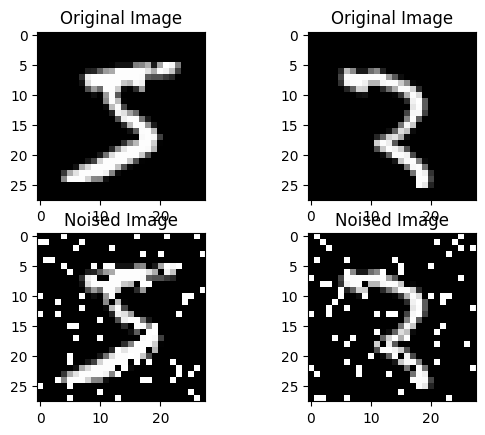

In [11]:
# Немного визуализации

f, axes = plt.subplots(2, 2)

# showing images with gaussian noise
axes[0, 0].imshow(xtrain[0], cmap="gray")
axes[0, 0].set_title("Original Image")
axes[1, 0].imshow(traindata[0], cmap='gray')
axes[1, 0].set_title("Noised Image")

# showing images with speckle noise
axes[0, 1].imshow(xtrain[500], cmap='gray')
axes[0, 1].set_title("Original Image")
axes[1, 1].imshow(traindata[500], cmap="gray")
axes[1, 1].set_title("Noised Image")

In [12]:
# Создаём класс для датасета

class noisedDataset(torch.utils.data.Dataset):

    def __init__(self, datasetnoised, datasetclean, labels, transform):
        self.noise = datasetnoised
        self.clean = datasetclean
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.noise)

    def __getitem__(self, idx):
        xNoise = self.noise[idx]
        xClean = self.clean[idx]
        y = self.labels[idx]

        if self.transform != None:
            xNoise = self.transform(xNoise)
            xClean = self.transform(xClean)

        return (xNoise, xClean, y)

In [13]:
# Создаём сеты для DataLoader'а
tsfms = T.Compose([
    T.ToTensor()
])

trainset = noisedDataset(traindata, xtrain, ytrain, tsfms)
testset = noisedDataset(testdata, xtest, ytest, tsfms)

In [14]:
# Создаём сам DataLoader
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

In [15]:
# Используем cuda по возможности
if torch.cuda.is_available() == True:
    device = "cuda:0"
else:
    device = "cpu"

In [16]:
# Берём несколько изображений для проверки на корректность работы 
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [17]:
dirty.shape

torch.Size([32, 784])

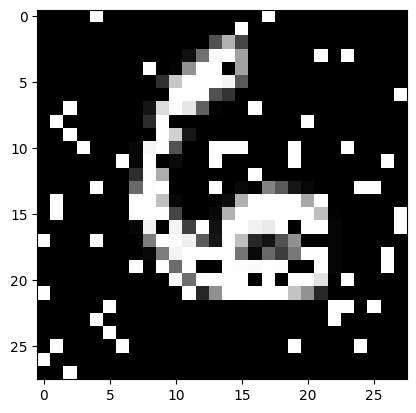

In [18]:
plot(dirty[2])

In [19]:
# Проверка инициализации модели
model = Autoencoder(28 * 28, 32)

# Берём один батч
X, y = dirty, clean

# Применяем модель
Y = model(X)
X.shape, Y.shape

(torch.Size([32, 784]), torch.Size([32, 784]))

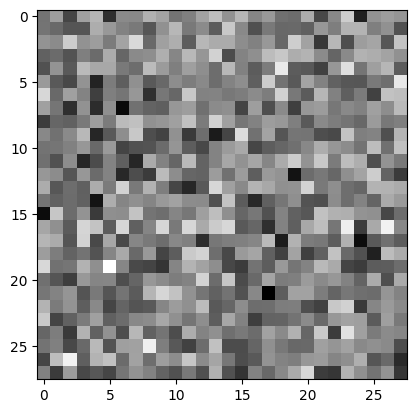

In [20]:
plot(Y[2])

## Задаём функции потерь

In [21]:
def diagram(image):
    # Получаем размер изображения
    h = int(np.sqrt(image.shape[0]))
    image_sq = image.reshape((h, h))

    # Создаём кубический комплекс
    cmplx = gd.CubicalComplex(dimensions=(h, h), top_dimensional_cells=image)

    # Получаем персистентные пары для кубической фильтрации
    cmplx.compute_persistence()
    critical_pairs = cmplx.cofaces_of_persistence_pairs()

    # Получаем номер пикселя в исходном изображении
    bpx0_essential = critical_pairs[1][0][0] // h, critical_pairs[1][0][0] % h

    # Получаем критические пиксели, соответствующие персистентным парам
    try:
        bpx0 = [[critical_pairs[0][0][i][0] // h, critical_pairs[0][0][i][0] % h] for i in
                range(len(critical_pairs[0][0]))]
        dpx0 = [[critical_pairs[0][0][i][1] // h, critical_pairs[0][0][i][1] % h] for i in
                range(len(critical_pairs[0][0]))]
    except IndexError:
        bpx0 = [[]]
        dpx0 = [[]]

    try:
        bpx1 = [[critical_pairs[0][1][i][0] // h, critical_pairs[0][1][i][0] % h] for i in
                range(len(critical_pairs[0][1]))]
        dpx1 = [[critical_pairs[0][1][i][1] // h, critical_pairs[0][1][i][1] % h] for i in
                range(len(critical_pairs[0][1]))]
    except IndexError:
        bpx1 = [[]]
        dpx1 = [[]]

    idx0, idx1 = np.stack([bpx0, dpx0]).T, np.stack([bpx1, dpx1]).T

    # Добавляем нулевой гомологический класс
    pd0_essential = torch.tensor([[image_sq[bpx0_essential], torch.max(image)]])

    # получаем диаграмму устойчивости через индексацию
    if (len(idx0) != 0):
        pd0 = image_sq[idx0]
        pd0 = torch.vstack([pd0, pd0_essential])
    else:
        pd0 = pd0_essential

    if (len(idx1) != 0):
        pd1 = image_sq[idx1]
    else:
        pd1 = torch.zeros((1, 2))

    return pd0, pd1

In [22]:
# Функция для сравнения диаграмм устойчивости
def compare(image1, image2):
    first_pd0, first_pd1 = diagram(image1)
    second_pd0, second_pd1 = diagram(image2)

    return wasserstein_distance(first_pd0, second_pd0, enable_autodiff=True) + \
        wasserstein_distance(first_pd1, second_pd1, enable_autodiff=True)


# Функция топологических потерь
def topo_loss(output, target):
    loss = torch.tensor(0.)
    for i in range(len(output)):
        loss += compare(output[i], target[i])
    return (loss / len(output))

In [23]:
# Проверка работы функции
X_pd0, X_pd1 = diagram(X[7])
Y_pd0, Y_pd1 = diagram(Y[7])
#X_pd0, Y_pd0

In [24]:
# Проверка подсчёта расстояния между диаграммами
wasserstein_distance(X_pd0, Y_pd0, enable_autodiff=True)

/opt/conda/lib/python3.10/site-packages/gudhi/wasserstein/wasserstein.py:282: UserWarning: enable_autodiff=True and keep_essential_parts=True are incompatible together.
                      keep_essential_parts is set to False: only points with finite coordinates are considered
                      in the following.
                      
  warnings.warn('''enable_autodiff=True and keep_essential_parts=True are incompatible together.


tensor(743.0777, grad_fn=<SumBackward0>)

## Checking

Проверка работоспособности функции и вычисления градиента

In [25]:
for dirty, clean, label in tqdm((trainloader)):
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    clean = clean.view(clean.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
    break

  0%|          | 0/313 [00:00<?, ?it/s]


In [26]:
loss = topo_loss(dirty, clean)

In [27]:
loss.item()

5165.55615234375

In [28]:
loss.backward()

In [29]:
dirty.grad

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0156],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000, -0.0156,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.0156],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

## Train process

Обучение

In [30]:
%%time
batch_size = batch_size_value

history = np.zeros((n_repeats, n_epochs, 2))

mse_loss_fn = nn.MSELoss()
topo_loss_fn = topo_loss

for repeat_idx in range(n_repeats):

    # Инициализация DataLoader'а
    dataloader_train = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

    # Инициализация модели
    model = Autoencoder(28 * 28, 32)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print("{:3} {:6} {:6}".format(repeat_idx + 1, "MSE", "Topo"))

    for epoch_idx in range(n_epochs):

        # Обучение
        model.train()

        mse_loss_epoch = []
        topo_loss_epoch = []

        for X, y, label in tqdm(dataloader_train):
            X = X.view(X.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            y = y.view(y.size(0), -1).type(torch.FloatTensor).clone().detach().requires_grad_(True)
            mse_loss_batch = mse_loss_fn(model(X), y)
            topo_loss_batch = topo_loss_fn(model(X), y)
            loss_batch = mse_loss_batch + beta * topo_loss_batch

            loss_batch.backward()
            optimizer.step()
            optimizer.zero_grad()

            mse_loss_epoch.append(mse_loss_batch.detach())
            topo_loss_epoch.append(topo_loss_batch.detach())

        mse_loss_mean = np.mean(mse_loss_epoch)
        topo_loss_mean = np.mean(topo_loss_epoch)

        history[repeat_idx, epoch_idx, 0] = mse_loss_mean
        history[repeat_idx, epoch_idx, 1] = topo_loss_mean

        print("{:3} {:.4f} {:.4f}".format(epoch_idx, mse_loss_mean, topo_loss_mean))
    torch.save(model.state_dict(), f"custom_model_{repeat_idx + 1}.pt")
    print("\r")

  1 MSE    Topo  


100%|██████████| 313/313 [02:30<00:00,  2.08it/s]


  0 7976.0439 4806.7573


100%|██████████| 313/313 [02:36<00:00,  2.00it/s]


  1 7151.3906 4603.2212


100%|██████████| 313/313 [02:43<00:00,  1.91it/s]


  2 7050.2285 4200.6001


100%|██████████| 313/313 [02:50<00:00,  1.84it/s]


  3 7006.3276 4031.7263


100%|██████████| 313/313 [02:30<00:00,  2.07it/s]


  4 7014.9473 3829.7349


100%|██████████| 313/313 [02:26<00:00,  2.13it/s]


  5 7109.5732 3511.6438


100%|██████████| 313/313 [02:30<00:00,  2.07it/s]


  6 7177.1079 3267.9963


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


  7 7312.2964 2917.4084


100%|██████████| 313/313 [02:34<00:00,  2.03it/s]


  8 7363.1084 2754.9414


100%|██████████| 313/313 [02:37<00:00,  1.99it/s]


  9 7382.4121 2675.5554


100%|██████████| 313/313 [02:35<00:00,  2.02it/s]


 10 7407.0254 2591.4648


100%|██████████| 313/313 [02:31<00:00,  2.06it/s]


 11 7423.7158 2521.1460


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


 12 7428.0894 2489.3115


100%|██████████| 313/313 [02:27<00:00,  2.12it/s]


 13 7432.1069 2462.8306


100%|██████████| 313/313 [02:27<00:00,  2.13it/s]


 14 7433.9839 2439.2656


100%|██████████| 313/313 [02:26<00:00,  2.14it/s]


 15 7430.2651 2425.8533


100%|██████████| 313/313 [02:28<00:00,  2.11it/s]


 16 7429.6328 2414.0422


100%|██████████| 313/313 [02:28<00:00,  2.11it/s]


 17 7425.2163 2404.8069


100%|██████████| 313/313 [02:27<00:00,  2.12it/s]


 18 7422.7402 2394.2288


100%|██████████| 313/313 [02:28<00:00,  2.11it/s]


 19 7418.3916 2382.9282


100%|██████████| 313/313 [02:27<00:00,  2.13it/s]


 20 7414.3394 2378.0840


100%|██████████| 313/313 [02:32<00:00,  2.06it/s]


 21 7411.8579 2365.6682


100%|██████████| 313/313 [02:31<00:00,  2.07it/s]


 22 7406.2764 2358.4026


100%|██████████| 313/313 [02:32<00:00,  2.05it/s]


 23 7405.7563 2339.8384


100%|██████████| 313/313 [02:29<00:00,  2.09it/s]


 24 7407.5903 2328.7998


100%|██████████| 313/313 [02:30<00:00,  2.08it/s]


 25 7407.9312 2309.8225


100%|██████████| 313/313 [02:27<00:00,  2.13it/s]


 26 7412.1899 2289.0486


100%|██████████| 313/313 [02:26<00:00,  2.14it/s]


 27 7418.9658 2263.5847


100%|██████████| 313/313 [02:27<00:00,  2.12it/s]


 28 7426.3433 2230.3103


100%|██████████| 313/313 [02:27<00:00,  2.12it/s]


 29 7428.4160 2211.2048


100%|██████████| 313/313 [02:32<00:00,  2.06it/s]


 30 7434.6240 2185.6145


100%|██████████| 313/313 [02:32<00:00,  2.06it/s]


 31 7440.6982 2156.6313


100%|██████████| 313/313 [02:36<00:00,  2.00it/s]


 32 7438.2949 2143.2473


100%|██████████| 313/313 [02:37<00:00,  1.98it/s]


 33 7436.4219 2133.2583


100%|██████████| 313/313 [02:36<00:00,  2.00it/s]


 34 7430.6582 2127.0801


100%|██████████| 313/313 [02:32<00:00,  2.05it/s]


 35 7428.2476 2120.9260


100%|██████████| 313/313 [02:32<00:00,  2.05it/s]


 36 7425.6216 2114.9478


100%|██████████| 313/313 [02:34<00:00,  2.02it/s]


 37 7421.7861 2114.1025


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 38 7420.1519 2109.6187


100%|██████████| 313/313 [02:28<00:00,  2.11it/s]


 39 7415.8232 2106.3284


100%|██████████| 313/313 [02:28<00:00,  2.11it/s]


 40 7414.2939 2104.7559


100%|██████████| 313/313 [02:27<00:00,  2.12it/s]


 41 7415.0542 2094.0344


100%|██████████| 313/313 [02:26<00:00,  2.13it/s]


 42 7411.4209 2095.0312


100%|██████████| 313/313 [02:29<00:00,  2.09it/s]


 43 7412.7749 2085.7205


100%|██████████| 313/313 [02:31<00:00,  2.07it/s]


 44 7409.0928 2084.8489


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 45 7409.3062 2079.1196


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 46 7407.8354 2078.1191


100%|██████████| 313/313 [02:31<00:00,  2.06it/s]


 47 7404.1182 2075.7747


100%|██████████| 313/313 [02:26<00:00,  2.14it/s]


 48 7402.8228 2073.4683


100%|██████████| 313/313 [02:25<00:00,  2.16it/s]


 49 7403.0098 2069.2471

  2 MSE    Topo  


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


  0 7898.5210 4779.1719


100%|██████████| 313/313 [02:27<00:00,  2.12it/s]


  1 6976.4346 4560.0273


100%|██████████| 313/313 [02:29<00:00,  2.10it/s]


  2 6760.0742 4442.4111


100%|██████████| 313/313 [02:26<00:00,  2.13it/s]


  3 6690.9834 4334.7378


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


  4 6663.4507 4205.1279


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


  5 6679.9248 4054.9353


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


  6 6668.9438 3981.4160


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


  7 6645.5361 3951.7356


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


  8 6627.6982 3923.8391


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


  9 6626.5288 3880.1091


100%|██████████| 313/313 [02:22<00:00,  2.19it/s]


 10 6632.4360 3831.8889


100%|██████████| 313/313 [02:25<00:00,  2.16it/s]


 11 6644.5034 3782.3921


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 12 6668.0244 3711.7903


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


 13 6728.5503 3551.7122


100%|██████████| 313/313 [02:26<00:00,  2.14it/s]


 14 6785.0215 3398.0371


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 15 6823.6519 3281.3467


100%|██████████| 313/313 [02:23<00:00,  2.19it/s]


 16 6865.8896 3181.4158


100%|██████████| 313/313 [02:25<00:00,  2.14it/s]


 17 6901.5640 3086.2583


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]


 18 6924.3716 3017.8599


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 19 6933.3018 2988.8762


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]


 20 6938.9458 2966.1726


100%|██████████| 313/313 [02:26<00:00,  2.14it/s]


 21 6941.2139 2949.1035


100%|██████████| 313/313 [02:23<00:00,  2.17it/s]


 22 6948.5928 2922.9263


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]


 23 6955.4375 2905.3821


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


 24 6956.8076 2894.1729


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


 25 6964.2271 2874.8020


100%|██████████| 313/313 [02:26<00:00,  2.14it/s]


 26 6971.7061 2852.2368


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]


 27 6987.9663 2813.8303


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 28 6996.9458 2786.1426


100%|██████████| 313/313 [02:27<00:00,  2.12it/s]


 29 7010.6309 2756.3828


100%|██████████| 313/313 [02:25<00:00,  2.16it/s]


 30 7035.6631 2708.2607


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]


 31 7123.1406 2538.7520


100%|██████████| 313/313 [02:26<00:00,  2.13it/s]


 32 7193.5654 2384.9241


100%|██████████| 313/313 [02:25<00:00,  2.16it/s]


 33 7223.9585 2306.6553


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 34 7243.5625 2249.5503


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]


 35 7251.0952 2226.5850


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]


 36 7255.4922 2208.4741


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 37 7257.9312 2191.8469


100%|██████████| 313/313 [02:26<00:00,  2.13it/s]


 38 7257.9487 2186.0415


100%|██████████| 313/313 [02:26<00:00,  2.13it/s]


 39 7261.4360 2170.0730


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


 40 7261.6270 2164.9780


100%|██████████| 313/313 [02:25<00:00,  2.16it/s]


 41 7260.7739 2158.0674


100%|██████████| 313/313 [02:27<00:00,  2.12it/s]


 42 7260.8540 2149.9792


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


 43 7263.9736 2143.8862


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


 44 7262.4043 2136.9841


100%|██████████| 313/313 [02:26<00:00,  2.14it/s]


 45 7264.5576 2123.8196


100%|██████████| 313/313 [02:23<00:00,  2.17it/s]


 46 7267.0830 2115.6655


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]


 47 7266.8291 2108.8130


100%|██████████| 313/313 [02:26<00:00,  2.13it/s]


 48 7272.9092 2097.0149


100%|██████████| 313/313 [02:28<00:00,  2.11it/s]


 49 7274.9985 2083.6562

  3 MSE    Topo  


100%|██████████| 313/313 [02:18<00:00,  2.26it/s]


  0 8016.5815 4715.2056


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


  1 7115.2764 4491.4756


100%|██████████| 313/313 [02:26<00:00,  2.14it/s]


  2 7013.0474 4154.1602


100%|██████████| 313/313 [02:30<00:00,  2.09it/s]


  3 7080.3291 3739.3857


100%|██████████| 313/313 [02:30<00:00,  2.08it/s]


  4 7100.6836 3567.9761


100%|██████████| 313/313 [02:31<00:00,  2.07it/s]


  5 7114.4966 3454.8066


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


  6 7216.3843 3166.6924


100%|██████████| 313/313 [02:26<00:00,  2.13it/s]


  7 7352.5952 2830.6343


100%|██████████| 313/313 [02:29<00:00,  2.09it/s]


  8 7415.8003 2635.6973


100%|██████████| 313/313 [02:29<00:00,  2.09it/s]


  9 7432.3467 2551.7114


100%|██████████| 313/313 [02:29<00:00,  2.09it/s]


 10 7439.9312 2499.7415


100%|██████████| 313/313 [02:30<00:00,  2.09it/s]


 11 7452.1431 2451.5254


100%|██████████| 313/313 [02:26<00:00,  2.14it/s]


 12 7457.5176 2419.0325


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 13 7466.5991 2381.2205


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]


 14 7470.8657 2360.4714


100%|██████████| 313/313 [02:25<00:00,  2.15it/s]


 15 7479.4424 2322.5212


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


 16 7488.1987 2282.4609


100%|██████████| 313/313 [02:24<00:00,  2.16it/s]


 17 7489.3340 2262.2341


100%|██████████| 313/313 [02:25<00:00,  2.14it/s]


 18 7491.6357 2244.1443


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


 19 7491.9409 2225.2278


100%|██████████| 313/313 [02:22<00:00,  2.20it/s]


 20 7491.6519 2208.8235


100%|██████████| 313/313 [02:25<00:00,  2.16it/s]


 21 7490.8994 2191.4329


100%|██████████| 313/313 [02:26<00:00,  2.13it/s]


 22 7490.6143 2178.2412


100%|██████████| 313/313 [02:23<00:00,  2.17it/s]


 23 7486.1821 2174.6716


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


 24 7484.8994 2160.0554


100%|██████████| 313/313 [02:30<00:00,  2.09it/s]


 25 7479.8081 2153.1980


100%|██████████| 313/313 [02:32<00:00,  2.05it/s]


 26 7481.0249 2138.4282


100%|██████████| 313/313 [02:27<00:00,  2.12it/s]


 27 7483.7490 2119.4604


100%|██████████| 313/313 [02:27<00:00,  2.13it/s]


 28 7480.9331 2111.0981


100%|██████████| 313/313 [02:27<00:00,  2.13it/s]


 29 7470.2715 2104.2019


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 30 7460.6509 2099.0962


100%|██████████| 313/313 [02:26<00:00,  2.14it/s]


 31 7455.2876 2088.3552


100%|██████████| 313/313 [02:26<00:00,  2.14it/s]


 32 7444.8896 2089.7815


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 33 7442.1348 2081.7549


100%|██████████| 313/313 [02:26<00:00,  2.14it/s]


 34 7438.0527 2076.3447


100%|██████████| 313/313 [02:32<00:00,  2.05it/s]


 35 7432.5137 2077.6855


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]


 36 7426.4810 2077.2190


100%|██████████| 313/313 [02:30<00:00,  2.08it/s]


 37 7424.4512 2068.6289


100%|██████████| 313/313 [02:32<00:00,  2.05it/s]


 38 7419.3081 2069.8748


100%|██████████| 313/313 [02:31<00:00,  2.06it/s]


 39 7416.5776 2064.4167


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


 40 7411.9937 2061.2722


100%|██████████| 313/313 [02:25<00:00,  2.16it/s]


 41 7412.1357 2059.6780


100%|██████████| 313/313 [02:26<00:00,  2.14it/s]


 42 7406.3242 2061.9363


100%|██████████| 313/313 [02:24<00:00,  2.17it/s]


 43 7406.3193 2053.0068


100%|██████████| 313/313 [02:23<00:00,  2.18it/s]


 44 7403.5801 2047.0343


100%|██████████| 313/313 [02:27<00:00,  2.12it/s]


 45 7402.1470 2051.2644


100%|██████████| 313/313 [02:29<00:00,  2.10it/s]


 46 7401.0278 2044.0439


100%|██████████| 313/313 [02:31<00:00,  2.07it/s]


 47 7396.1748 2043.7400


100%|██████████| 313/313 [02:31<00:00,  2.07it/s]


 48 7396.2158 2042.0072


100%|██████████| 313/313 [02:33<00:00,  2.04it/s]

 49 7395.7388 2039.5343

CPU times: user 11h 58min 12s, sys: 43.1 s, total: 11h 58min 55s
Wall time: 6h 9min 40s


In [31]:
x = np.arange(n_epochs)
mse_ci1 = history.mean(axis=0)[:, 0] - history.std(axis=0)[:, 0]
mse_ci2 = history.mean(axis=0)[:, 0] + history.std(axis=0)[:, 0]
topo_ci1 = history.mean(axis=0)[:, 1] - history.std(axis=0)[:, 1]
topo_ci2 = history.mean(axis=0)[:, 1] + history.std(axis=0)[:, 1]

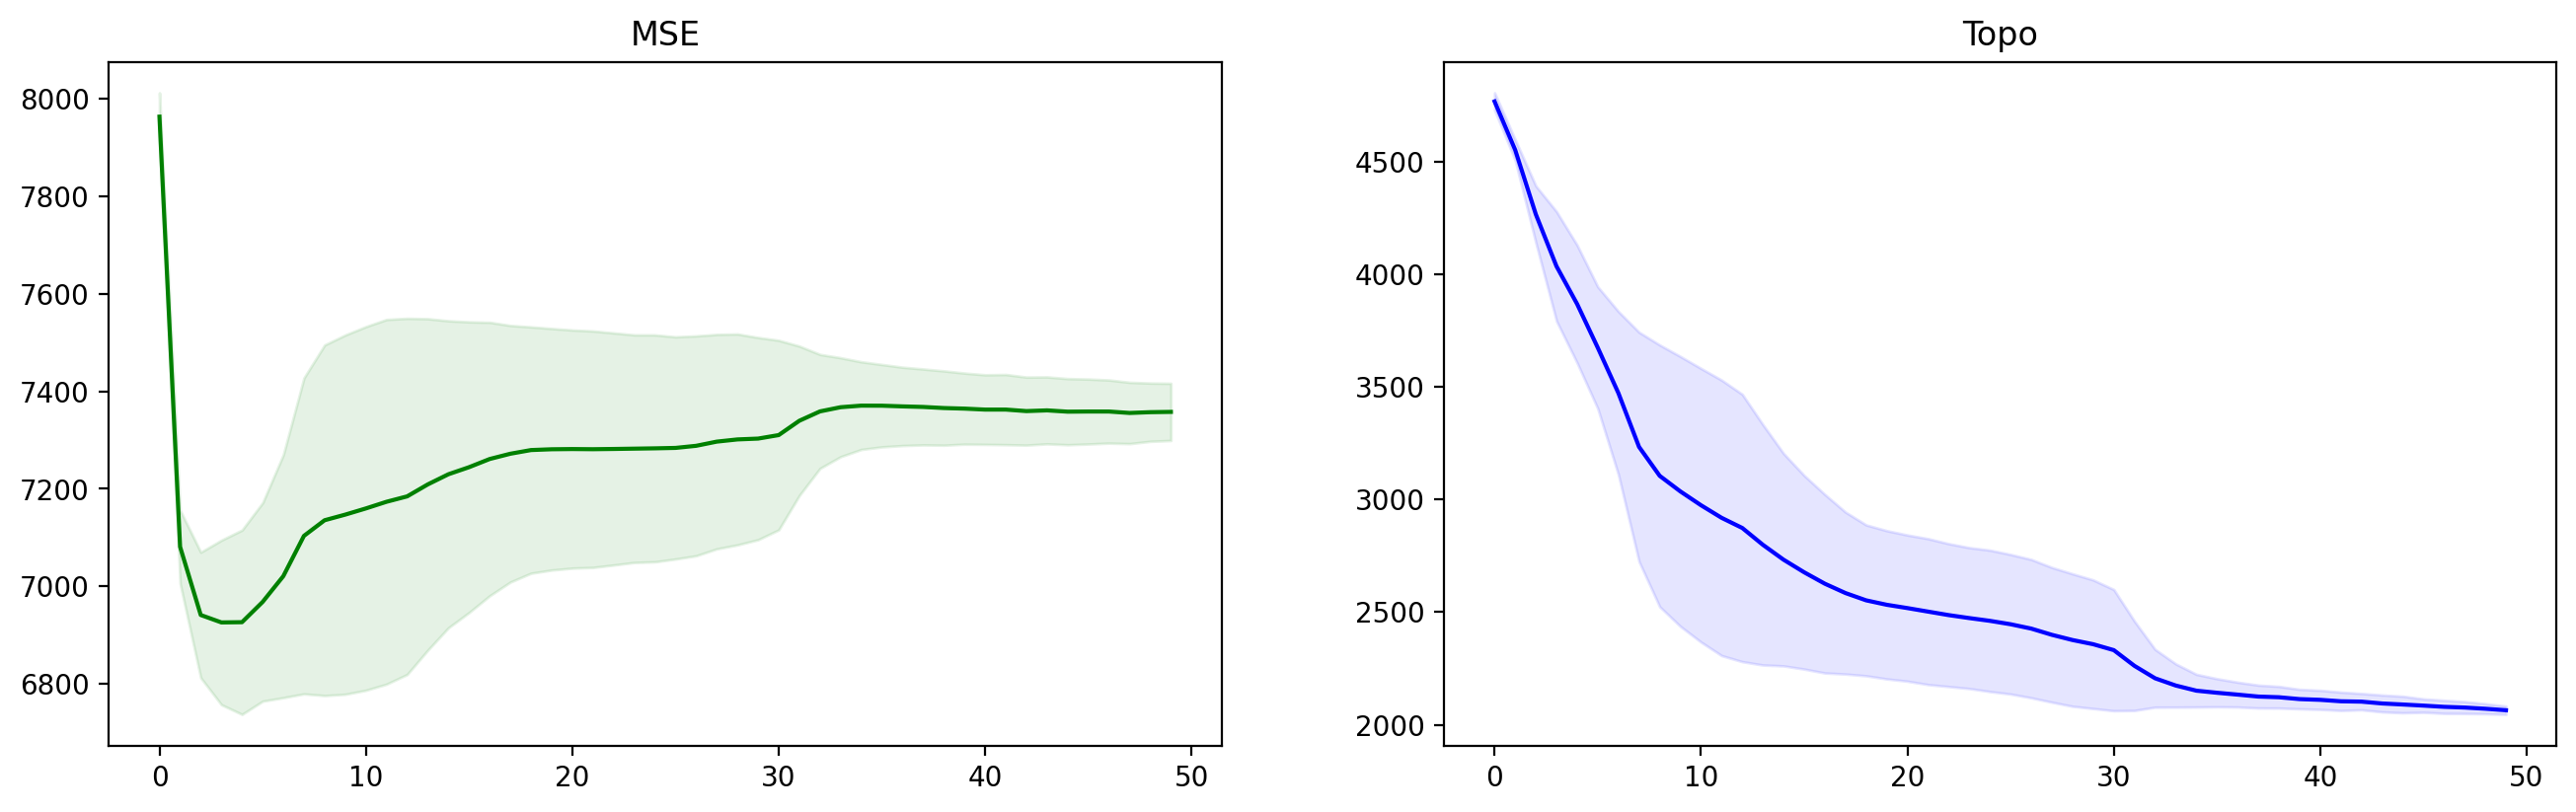

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4.5), dpi=200)
ax[0].set_title("MSE")
ax[1].set_title("Topo")
ax[0].plot(history.mean(axis=0)[:, 0], c="g", label="MSE")
ax[0].fill_between(x, mse_ci1, mse_ci2, color="g", alpha=0.1)
ax[1].plot(history.mean(axis=0)[:, 1], c="b", label="Topo")
ax[1].fill_between(x, topo_ci1, topo_ci2, color="b", alpha=0.1)
plt.show()

In [33]:
def plot_dgm(img, ax):
    cmplx = gd.CubicalComplex(dimensions=img.shape, top_dimensional_cells=img.flatten())
    diag = cmplx.persistence()
    gd.plot_persistence_diagram(diag, legend=True, axes=ax)

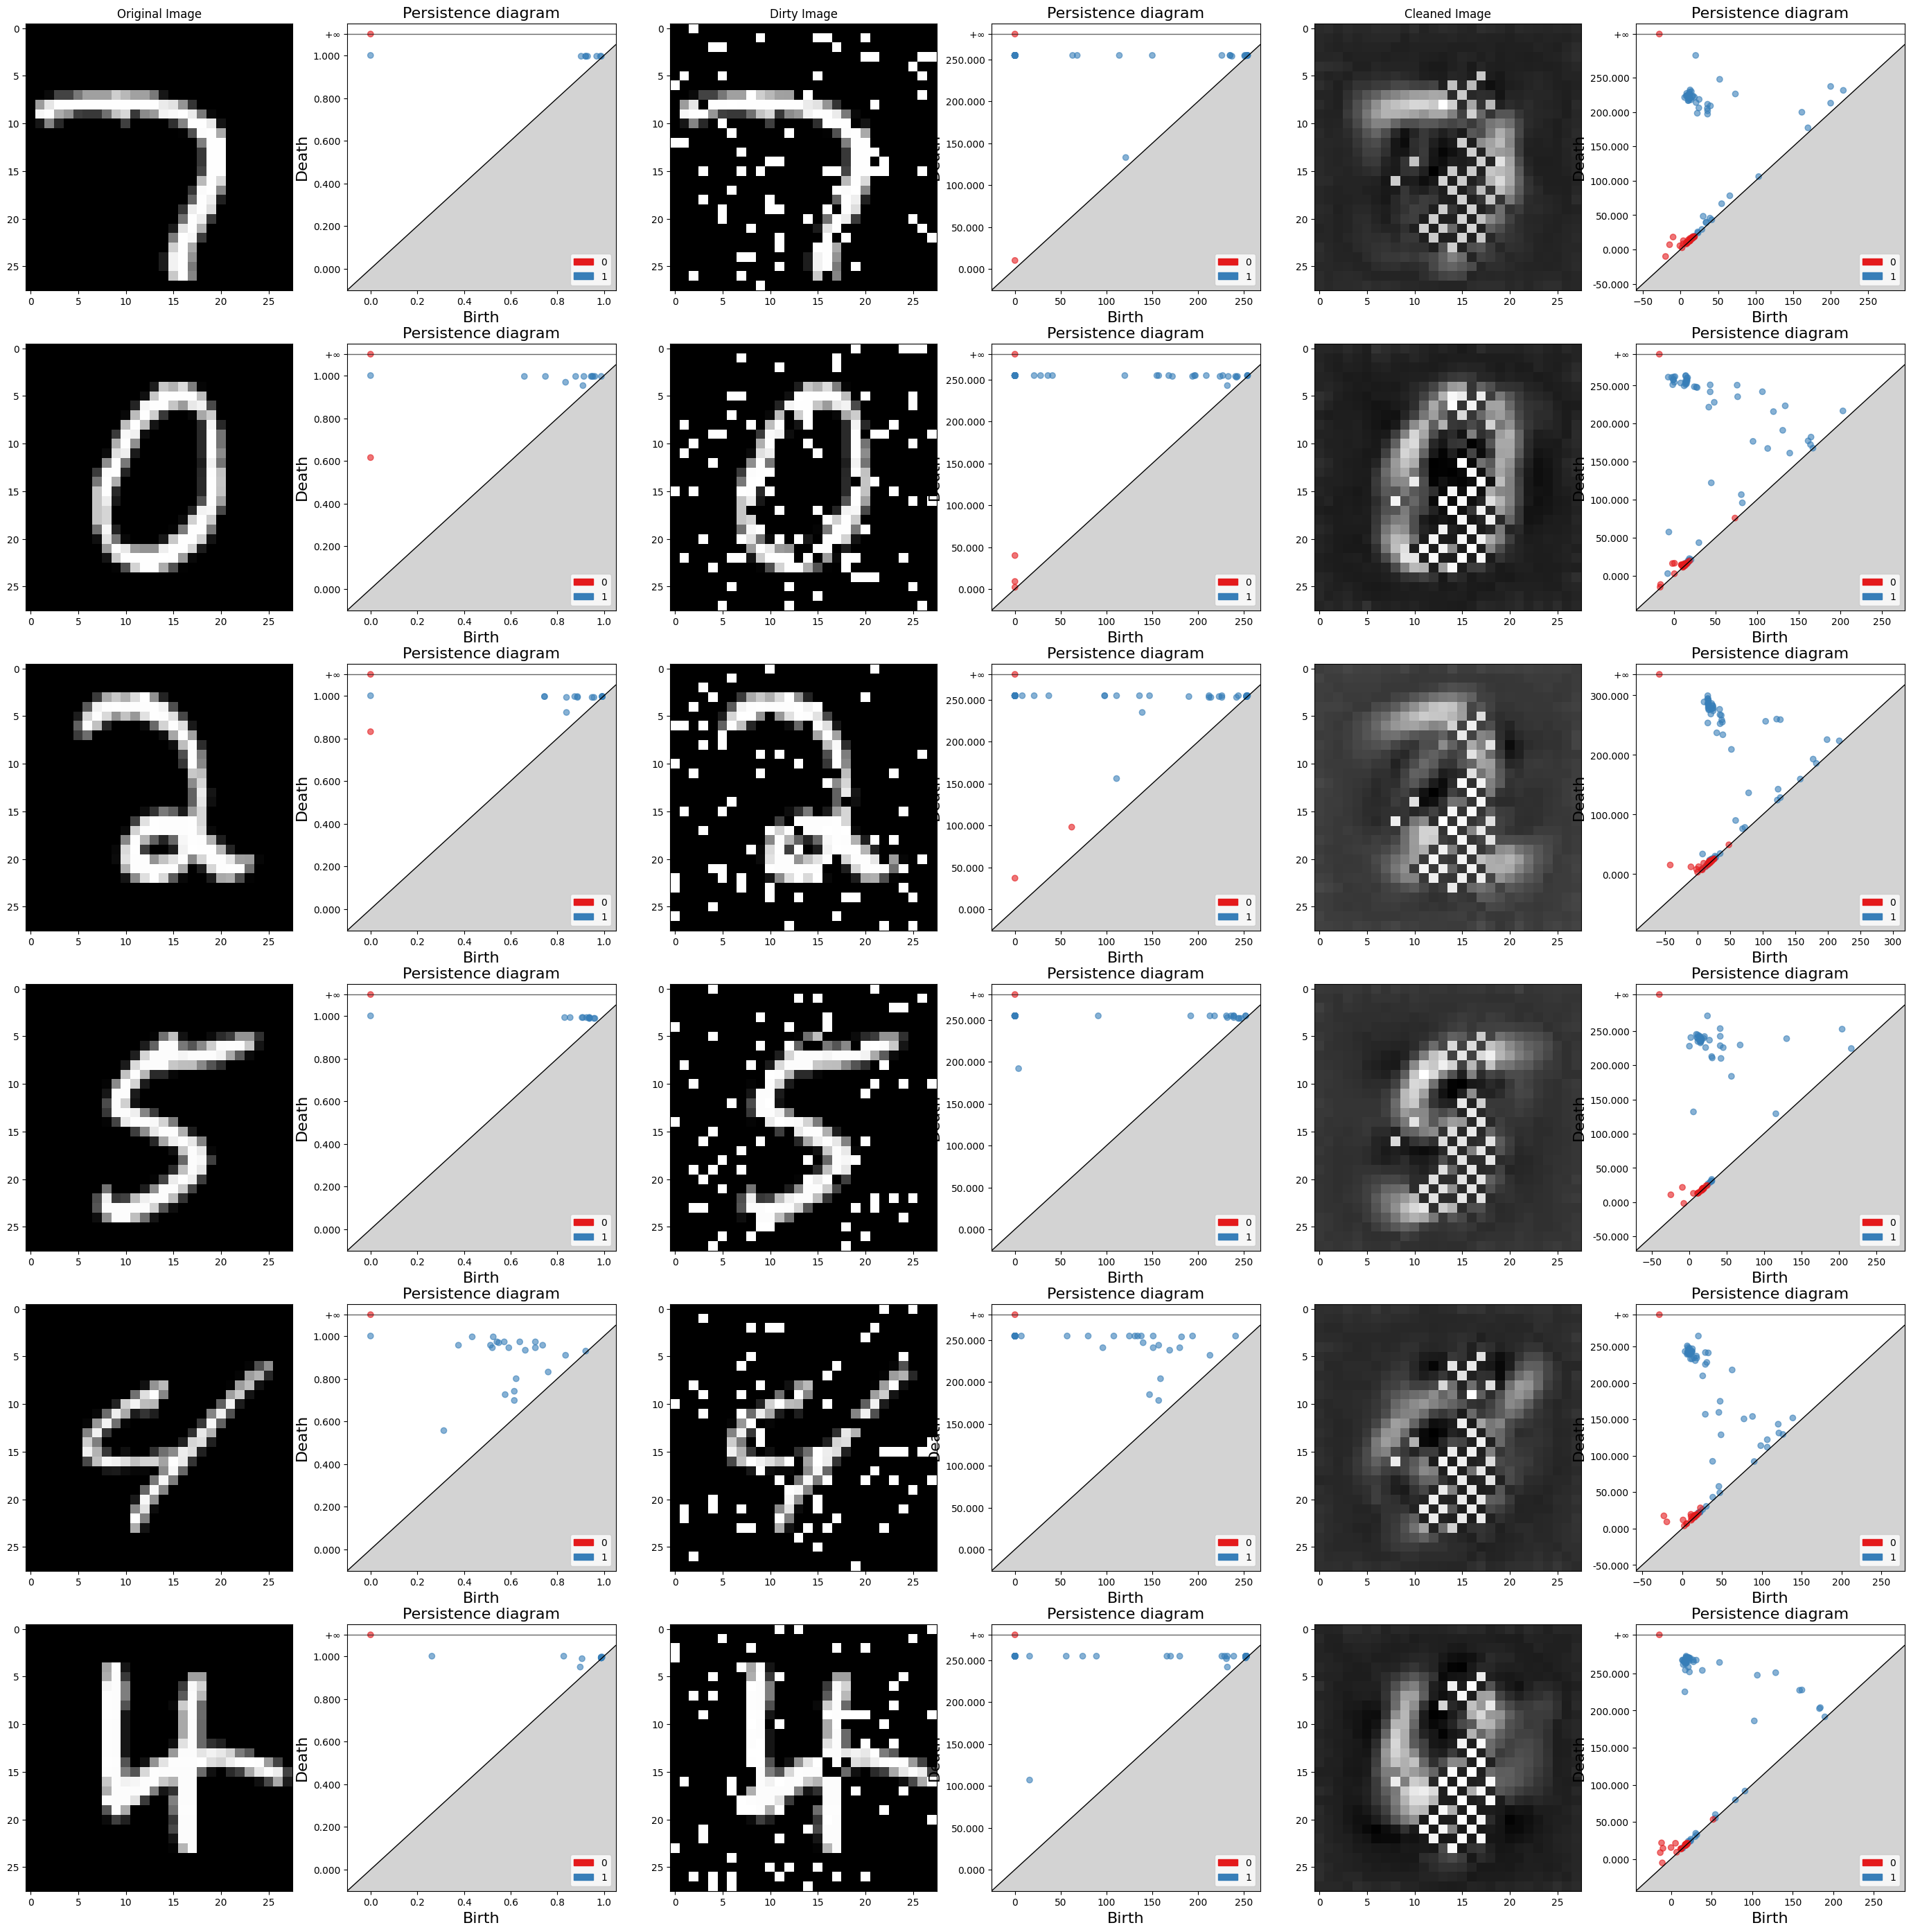

In [34]:
# Результаты работы модели на 6-и случайных примерах

f, axes = plt.subplots(6, 6, figsize=(35, 35))
axes[0, 0].set_title("Original Image")
axes[0, 1].set_title("Original diagram")
axes[0, 2].set_title("Dirty Image")
axes[0, 3].set_title("Dirty diagram")
axes[0, 4].set_title("Cleaned Image")
axes[0, 5].set_title("Cleaned diagram")

test_imgs = np.random.randint(0, 500, size=6)
for idx in range((6)):
    dirty = testset[test_imgs[idx]][0]
    clean = testset[test_imgs[idx]][1]
    label = testset[test_imgs[idx]][2]
    dirty = dirty.view(dirty.size(0), -1).type(torch.FloatTensor)
    dirty = dirty.to(device)
    output = model(dirty)

    output = output.view(1, 28, 28)
    output = output.permute(1, 2, 0).squeeze(2)
    output = output.detach().cpu().numpy()

    dirty = dirty.view(1, 28, 28)
    dirty = dirty.permute(1, 2, 0).squeeze(2)
    dirty = dirty.detach().cpu().numpy()

    clean = clean.permute(1, 2, 0).squeeze(2)
    clean = clean.detach().cpu().numpy()

    axes[idx, 0].imshow(clean, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][1], axes[idx, 1])

    axes[idx, 2].imshow(dirty, cmap="gray")
    plot_dgm(testset[test_imgs[idx]][0], axes[idx, 3])
    axes[idx, 4].imshow(output, cmap="gray")
    plot_dgm(output, axes[idx, 5])

In [35]:
# Выводим историю loss'ов (на всякий случай)
print(history)

[[[7976.04394531 4806.75732422]
  [7151.390625   4603.22119141]
  [7050.22851562 4200.60009766]
  [7006.32763672 4031.72631836]
  [7014.94726562 3829.73486328]
  [7109.57324219 3511.64379883]
  [7177.10791016 3267.99633789]
  [7312.29638672 2917.40844727]
  [7363.10839844 2754.94140625]
  [7382.41210938 2675.55541992]
  [7407.02539062 2591.46484375]
  [7423.71582031 2521.14599609]
  [7428.08935547 2489.31152344]
  [7432.10693359 2462.83056641]
  [7433.98388672 2439.265625  ]
  [7430.26513672 2425.85327148]
  [7429.6328125  2414.04223633]
  [7425.21630859 2404.80688477]
  [7422.74023438 2394.22875977]
  [7418.39160156 2382.92822266]
  [7414.33935547 2378.08398438]
  [7411.85791016 2365.66821289]
  [7406.27636719 2358.40258789]
  [7405.75634766 2339.83837891]
  [7407.59033203 2328.79980469]
  [7407.93115234 2309.82250977]
  [7412.18994141 2289.04858398]
  [7418.96582031 2263.5847168 ]
  [7426.34326172 2230.31030273]
  [7428.41601562 2211.20483398]
  [7434.62402344 2185.61450195]
  [7440.